In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, fbeta_score
from sklearn.metrics import make_scorer, get_scorer, PrecisionRecallDisplay
from sklearn.base import BaseEstimator, ClassifierMixin
import tensorflow as tf

In [2]:
df = pd.read_csv(r"..\..\oblig3_og_4\student_performance.csv", delimiter=";")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance	                     4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

In [7]:
df_features = pd.DataFrame(StandardScaler().fit_transform(df.drop('Target', axis=1)), columns=df.drop('Target', axis=1).columns)
df_targets = pd.Series(np.array(LabelEncoder().fit_transform(df['Target'])))

In [8]:
global_random_state = 15

scoring = {
    'accuracy': get_scorer('accuracy'),
    'precision': make_scorer(precision_score, average='macro', zero_division=1.0),
    'recall': make_scorer(recall_score, average='macro', zero_division=1.0),
    'f1': make_scorer(f1_score, average='macro'),
    'roc_auc': make_scorer(roc_auc_score, multi_class='ovr', average='macro', response_method='predict_proba')   
}

def evaluate(estimator, X, y):
    scores = {}
    for (name,scorer) in scoring.items():
        scores[name] = scorer(estimator, X, y) 
    return scores

def train(features, targets, estimator, params, scoring=scoring, refit='f1', random_state=global_random_state, outer_splits=5, inner_splits=4):

    outer_cv = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=global_random_state)
    inner_cv = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=global_random_state)

    scores_train = []
    scores_test = []
    estimators = []
    cv_results = []

    # Loop through all test folds
    for (train_index, test_index) in outer_cv.split(features, targets):
        
        grid = GridSearchCV(
            estimator,
            params, 
            scoring=scoring, 
            refit=refit,
            error_score='raise', 
            cv=inner_cv)
        grid.fit(features.iloc[train_index], targets.iloc[train_index])        
        
        evaluation_train = evaluate(grid, features.iloc[train_index], targets.iloc[train_index])
        evaluation_test = evaluate(grid, features.iloc[test_index], targets.iloc[test_index])
        
        scores_train.append(evaluation_train)
        scores_test.append(evaluation_test)
        
        estimators.append(grid.best_estimator_)
        cv_results.append(pd.DataFrame(grid.cv_results_))
        print("*")

    return estimators, pd.DataFrame(scores_train), pd.DataFrame(scores_test), pd.concat(cv_results, names=['test_split'], keys=range(outer_splits))

def print_estimators(estimators):
    for estimatior in estimators:
        print(estimatior)

In [9]:
rf_params = {
    'max_depth': [5, 10, 20, 30, 40],
    'min_samples_leaf': [2,4,8],
    'min_samples_split': [8, 16, 24],
    'criterion': ['gini'],
    'n_estimators': [500],
}
rf_estimators, rf_scores_train, rf_scores_test, rf_cv_results = train(df_features, df_targets,
    RandomForestClassifier(random_state=global_random_state),
    rf_params, outer_splits=3, inner_splits=3)

*
*
*


<Axes: xlabel='param_min_samples_split', ylabel='mean_test_f1'>

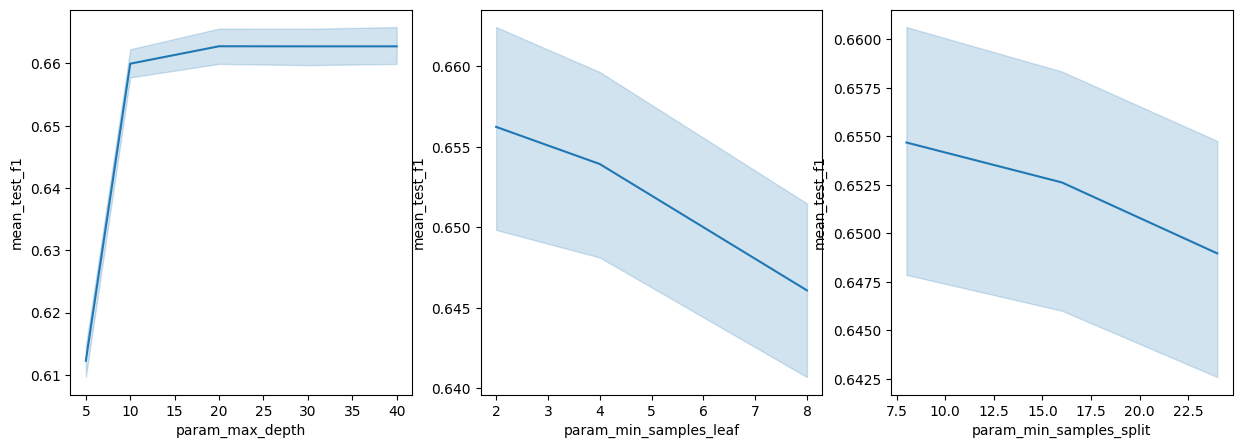

In [11]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
sb.lineplot(data=rf_cv_results, x='param_max_depth', y='mean_test_f1', ax=ax[0])
sb.lineplot(data=rf_cv_results, x='param_min_samples_leaf', y='mean_test_f1', ax=ax[1])
sb.lineplot(data=rf_cv_results, x='param_min_samples_split', y='mean_test_f1', ax=ax[2])

In [13]:
rf_scores_test

,accuracy,precision,recall,f1,roc_auc
0,0.768136,0.725794,0.681552,0.694202,0.884442
1,0.771525,0.721415,0.679272,0.689220,0.885299
2,0.776798,0.732672,0.671644,0.682406,0.894008


In [14]:
rf_scores_train

,accuracy,precision,recall,f1,roc_auc
0,0.934554,0.952402,0.901769,0.922315,0.994688
1,0.937606,0.954514,0.904838,0.924994,0.994899
2,0.932203,0.952139,0.901130,0.922035,0.994950


In [12]:
print_estimators(rf_estimators)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=8,
                       n_estimators=500, random_state=15)
RandomForestClassifier(max_depth=30, min_samples_leaf=2, min_samples_split=8,
                       n_estimators=500, random_state=15)
RandomForestClassifier(max_depth=30, min_samples_leaf=2, min_samples_split=8,
                       n_estimators=500, random_state=15)


In [15]:
rf_params = {
    'max_depth': [20, 25, 30],
    'min_samples_leaf': [2],
    'min_samples_split': [8],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'n_estimators': [500],
}
rf_estimators_2, rf_scores_train_2, rf_scores_test_2, rf_cv_results_2 = train(df_features, df_targets,
    RandomForestClassifier(random_state=global_random_state),
    rf_params, outer_splits=5, inner_splits=4)

*
*
*
*
*


<Axes: xlabel='param_criterion', ylabel='mean_test_f1'>

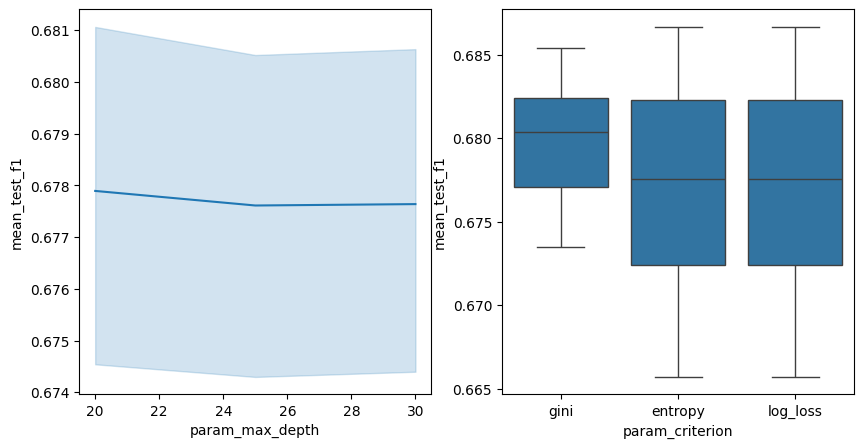

In [22]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sb.lineplot(data=rf_cv_results_2, x='param_max_depth', y='mean_test_f1', ax=ax[0])
sb.boxplot(data=rf_cv_results_2, x='param_criterion', y='mean_test_f1', ax=ax[1])


In [24]:
rf_scores_test_2.describe()

,accuracy,precision,recall,f1,roc_auc
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.771702,0.723340,0.677115,0.687098,0.889624
std,0.016360,0.023740,0.013896,0.014308,0.004420
min,0.744633,0.686797,0.652373,0.661592,0.885183
25%,0.768362,0.712287,0.681799,0.692129,0.886515
50%,0.779661,0.735805,0.682273,0.692974,0.889868
75%,0.780543,0.737418,0.683983,0.693436,0.889962
max,0.785311,0.744392,0.685145,0.695359,0.896595


In [25]:
rf_scores_train_2.describe()

,accuracy,precision,recall,f1,roc_auc
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.935296,0.953194,0.904233,0.924323,0.995083
std,0.002644,0.001743,0.005132,0.004068,0.000673
min,0.931902,0.950867,0.898258,0.919452,0.994592
25%,0.934445,0.952589,0.901974,0.922801,0.994739
50%,0.935292,0.953349,0.902412,0.922855,0.994797
75%,0.935593,0.953467,0.906952,0.926364,0.995034
max,0.939248,0.955698,0.911570,0.930140,0.996253


In [26]:
rf_estimators_2

[RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=8,
                        n_estimators=500, random_state=15),
 RandomForestClassifier(criterion='entropy', max_depth=20, min_samples_leaf=2,
                        min_samples_split=8, n_estimators=500, random_state=15),
 RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=8,
                        n_estimators=500, random_state=15),
 RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=8,
                        n_estimators=500, random_state=15),
 RandomForestClassifier(max_depth=25, min_samples_leaf=2, min_samples_split=8,
                        n_estimators=500, random_state=15)]

In [28]:
rf_params = {
    'max_depth': [10, 20],
    'min_samples_leaf': [2],
    'min_samples_split': [4, 8],
    'criterion': ['gini'],
    'n_estimators': [250, 500, 1000],
}
rf_estimators_3, rf_scores_train_3, rf_scores_test_3, rf_cv_results_3 = train(df_features, df_targets,
    RandomForestClassifier(random_state=global_random_state),
    rf_params, outer_splits=5, inner_splits=4)

*
*
*
*
*


<Axes: xlabel='param_min_samples_split', ylabel='mean_test_f1'>

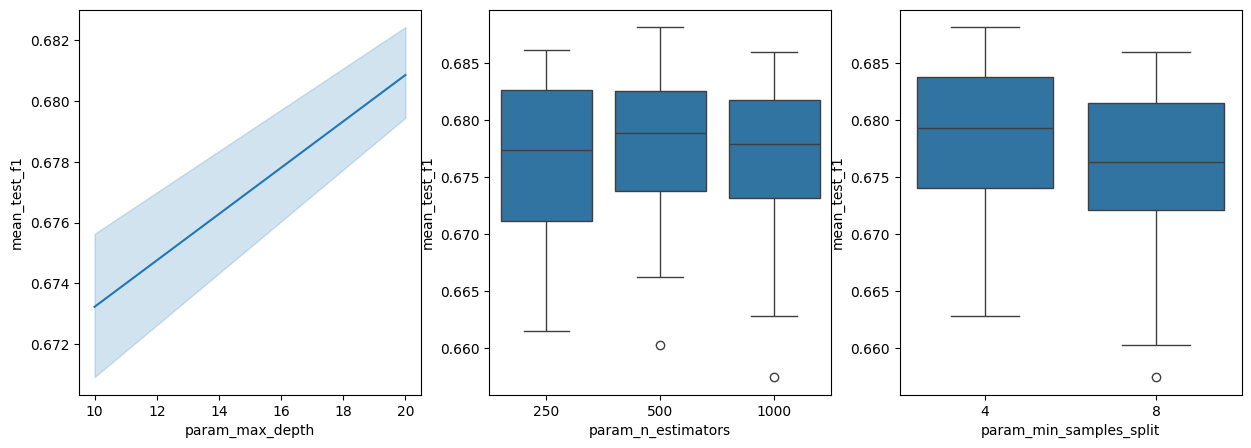

In [40]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
sb.lineplot(data=rf_cv_results_3, x='param_max_depth', y='mean_test_f1', ax=ax[0])
sb.boxplot(data=rf_cv_results_3, x='param_n_estimators', y='mean_test_f1', ax=ax[1])
sb.boxplot(data=rf_cv_results_3, x='param_min_samples_split', y='mean_test_f1', ax=ax[2])

In [41]:
rf_scores_test_3.describe()

,accuracy,precision,recall,f1,roc_auc
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.776222,0.735255,0.683163,0.695181,0.889381
std,0.017324,0.026703,0.018586,0.019736,0.005539
min,0.746893,0.693959,0.652539,0.663130,0.882807
25%,0.776271,0.726777,0.679507,0.691085,0.885235
50%,0.780543,0.739617,0.691443,0.701301,0.890691
75%,0.786441,0.754445,0.692694,0.706600,0.891227
max,0.790960,0.761477,0.699630,0.713788,0.896943


In [54]:
rf_scores_train_3.describe()

,accuracy,precision,recall,f1,roc_auc
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.948407,0.961395,0.923144,0.938841,0.993085
std,0.031859,0.025885,0.047661,0.040573,0.011377
min,0.898841,0.919671,0.847943,0.874051,0.973009
25%,0.933616,0.952413,0.903157,0.923436,0.994870
50%,0.968918,0.977404,0.953474,0.964416,0.999160
75%,0.969200,0.978337,0.953548,0.964795,0.999180
max,0.971461,0.979150,0.957597,0.967510,0.999205


In [55]:
rf_estimators_3

[RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=4,
                        n_estimators=250, random_state=15),
 RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=4,
                        n_estimators=500, random_state=15),
 RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=4,
                        n_estimators=500, random_state=15),
 RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=4,
                        n_estimators=1000, random_state=15),
 RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=8,
                        n_estimators=1000, random_state=15)]

In [56]:
rf_params = {
    'max_depth': [20],
    'min_samples_leaf': [2],
    'min_samples_split': [4],
    'criterion': ['gini'],
    'n_estimators': [500],
}
rf_estimators_final, rf_scores_train_final, rf_scores_test_final, rf_cv_results_final = train(df_features, df_targets,
    RandomForestClassifier(random_state=global_random_state),
    rf_params, outer_splits=5, inner_splits=4)

*
*
*
*
*


In [81]:
rf_scores_test_final.describe()

,accuracy,precision,recall,f1,roc_auc
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.778934,0.738182,0.688615,0.700557,0.890295
std,0.013323,0.019563,0.010252,0.011268,0.004899
min,0.758192,0.714142,0.677446,0.689268,0.885235
25%,0.776271,0.726777,0.681617,0.693022,0.886598
50%,0.781674,0.737957,0.688502,0.700661,0.890263
75%,0.784181,0.746355,0.691443,0.701301,0.891677
max,0.794350,0.765679,0.704065,0.718531,0.897700


In [80]:
rf_scores_train_final.describe()

,accuracy,precision,recall,f1,roc_auc
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.968976,0.977764,0.953909,0.964795,0.999201
std,0.001963,0.001484,0.002852,0.002272,0.000063
min,0.965527,0.975364,0.949146,0.961013,0.999139
25%,0.969200,0.977404,0.953548,0.964416,0.999153
50%,0.970048,0.978283,0.955100,0.965695,0.999180
75%,0.970048,0.978619,0.955343,0.966229,0.999254
max,0.970056,0.979149,0.956410,0.966620,0.999280


gradiens

In [16]:
gb_params = {
    "n_estimators": [500],
    "learning_rate": [0.0001, 0.001, 0.1],
    'subsample': [0.1, 0.25, 0.5],
    'min_samples_split': [4], 
    'max_depth': [4, 8],
   
}

gb_estimators, gb_scores_train, gb_scores_test, gb_cv_results = train(df_features, df_targets,
    GradientBoostingClassifier(random_state=global_random_state),
    gb_params, outer_splits=3, inner_splits=3)

*
*
*


<Axes: xlabel='param_subsample', ylabel='mean_test_f1'>

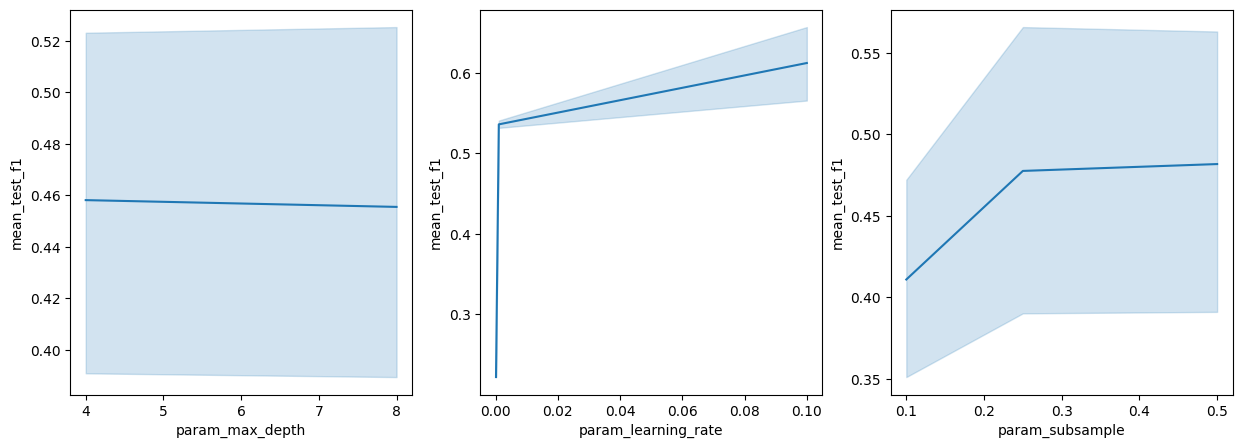

In [78]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
sb.lineplot(data=gb_cv_results, x='param_max_depth', y='mean_test_f1', ax=ax[0])
sb.lineplot(data=gb_cv_results, x='param_learning_rate', y='mean_test_f1', ax=ax[1])
sb.lineplot(data=gb_cv_results, x='param_subsample', y='mean_test_f1', ax=ax[2])

In [17]:
gb_scores_train.describe()

,accuracy,precision,recall,f1,roc_auc
count,3.0,3.0,3.0,3.0,3.0
mean,1.0,1.0,1.0,1.0,1.0
std,0.0,0.0,0.0,0.0,0.0
min,1.0,1.0,1.0,1.0,1.0
25%,1.0,1.0,1.0,1.0,1.0
50%,1.0,1.0,1.0,1.0,1.0
75%,1.0,1.0,1.0,1.0,1.0
max,1.0,1.0,1.0,1.0,1.0


In [18]:
gb_scores_test.describe()

,accuracy,precision,recall,f1,roc_auc
count,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.768765,0.715885,0.692443,0.700629,0.881028
std,0.014023,0.019620,0.012464,0.014690,0.006960
min,0.760000,0.700336,0.682395,0.688561,0.873497
25%,0.760678,0.704863,0.685469,0.692450,0.877932
50%,0.761356,0.709389,0.688543,0.696339,0.882367
75%,0.773147,0.723659,0.697467,0.706662,0.884794
max,0.784939,0.737929,0.706390,0.716985,0.887222


In [20]:
print_estimators(gb_estimators)

GradientBoostingClassifier(max_depth=4, min_samples_split=4, n_estimators=500,
                           random_state=15, subsample=0.5)
GradientBoostingClassifier(max_depth=4, min_samples_split=4, n_estimators=500,
                           random_state=15, subsample=0.5)
GradientBoostingClassifier(max_depth=4, min_samples_split=4, n_estimators=500,
                           random_state=15, subsample=0.5)


In [ ]:
gb_params = {
    "n_estimators": [500, 1000],
    "learning_rate": [0.1, 0.2],
    'subsample': [0.5, 0.75],
    'min_samples_split': [4, 8], 
    'max_depth': [2, 4],   
}

gb_estimators_2, gb_scores_train_2, gb_scores_test_2, gb_cv_results_2 = train(df_features, df_targets,
    GradientBoostingClassifier(random_state=global_random_state),
    gb_params, outer_splits=3, inner_splits=3)

*
*
*


<Axes: xlabel='param_subsample', ylabel='mean_test_f1'>

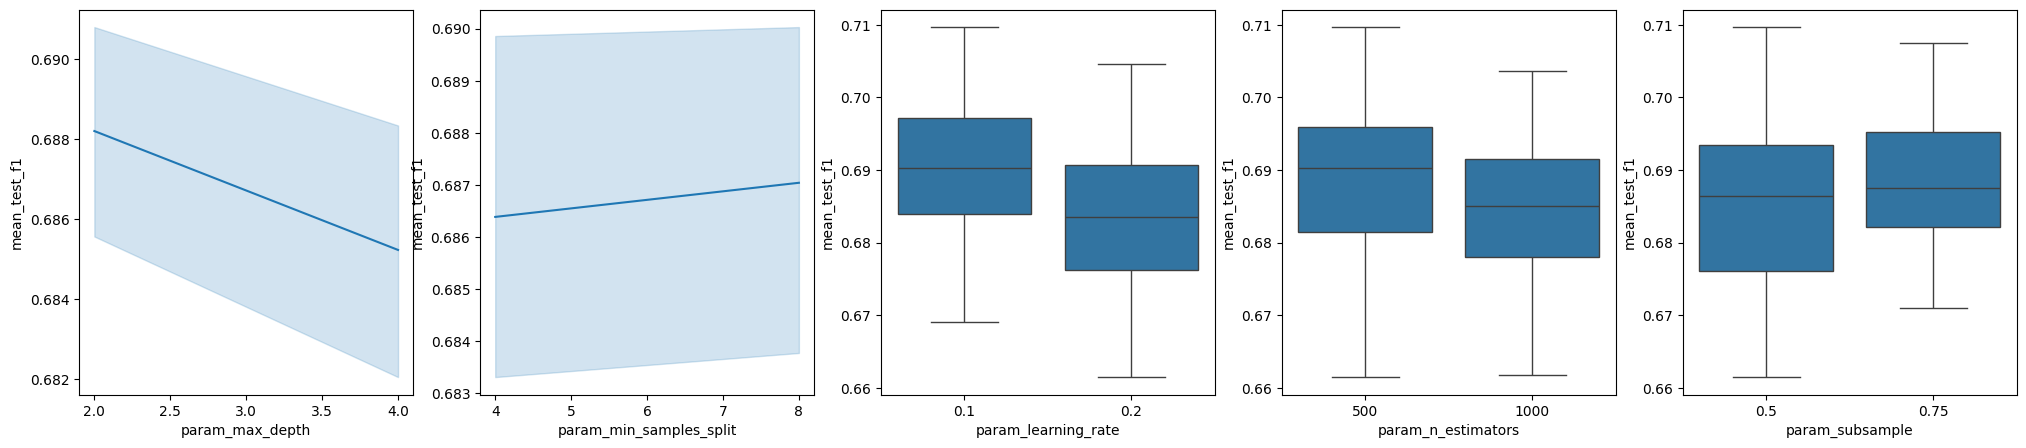

In [31]:
fig, ax = plt.subplots(1,5, figsize=(25,5))
sb.lineplot(data=gb_cv_results_2, x='param_max_depth', y='mean_test_f1', ax=ax[0])
sb.lineplot(data=gb_cv_results_2, x='param_min_samples_split', y='mean_test_f1', ax=ax[1])
sb.boxplot(data=gb_cv_results_2, x='param_learning_rate', y='mean_test_f1', ax=ax[2])
sb.boxplot(data=gb_cv_results_2, x='param_n_estimators', y='mean_test_f1', ax=ax[3])
sb.boxplot(data=gb_cv_results_2, x='param_subsample', y='mean_test_f1', ax=ax[4])

In [34]:
gb_scores_test_2.describe()

,accuracy,precision,recall,f1,roc_auc
count,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.772606,0.718655,0.693265,0.701586,0.885217
std,0.008662,0.010227,0.004392,0.005320,0.008406
min,0.765424,0.709096,0.689243,0.698506,0.876349
25%,0.767797,0.713263,0.690922,0.698514,0.881291
50%,0.770169,0.717429,0.692601,0.698523,0.886233
75%,0.776197,0.723434,0.695276,0.703126,0.889651
max,0.782225,0.729440,0.697952,0.707729,0.893069


In [36]:
gb_scores_train_2.describe()

,accuracy,precision,recall,f1,roc_auc
count,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.889693,0.882585,0.844163,0.859796,0.971834
std,0.006279,0.006059,0.007644,0.006872,0.001635
min,0.882712,0.878528,0.835819,0.852862,0.970241
25%,0.887100,0.879102,0.840832,0.856392,0.970997
50%,0.891489,0.879676,0.845845,0.859921,0.971752
75%,0.893184,0.884613,0.848336,0.863263,0.972630
max,0.894880,0.889550,0.850827,0.866604,0.973509


In [37]:
gb_estimators_2

[GradientBoostingClassifier(max_depth=2, min_samples_split=4, n_estimators=500,
                            random_state=15, subsample=0.5),
 GradientBoostingClassifier(max_depth=2, min_samples_split=8, n_estimators=500,
                            random_state=15, subsample=0.75),
 GradientBoostingClassifier(max_depth=2, min_samples_split=4, n_estimators=500,
                            random_state=15, subsample=0.75)]

In [38]:
gb_params = {
    "n_estimators": [250, 500],
    "learning_rate": [0.1],
    'subsample': [0.75, 0.85],
    'min_samples_split': [8, 16], 
    'max_depth': [2],   
}

gb_estimators_3, gb_scores_train_3, gb_scores_test_3, gb_cv_results_3 = train(df_features, df_targets,
    GradientBoostingClassifier(random_state=global_random_state),
    gb_params, outer_splits=3, inner_splits=3)

*
*
*


<Axes: xlabel='param_subsample', ylabel='mean_test_f1'>

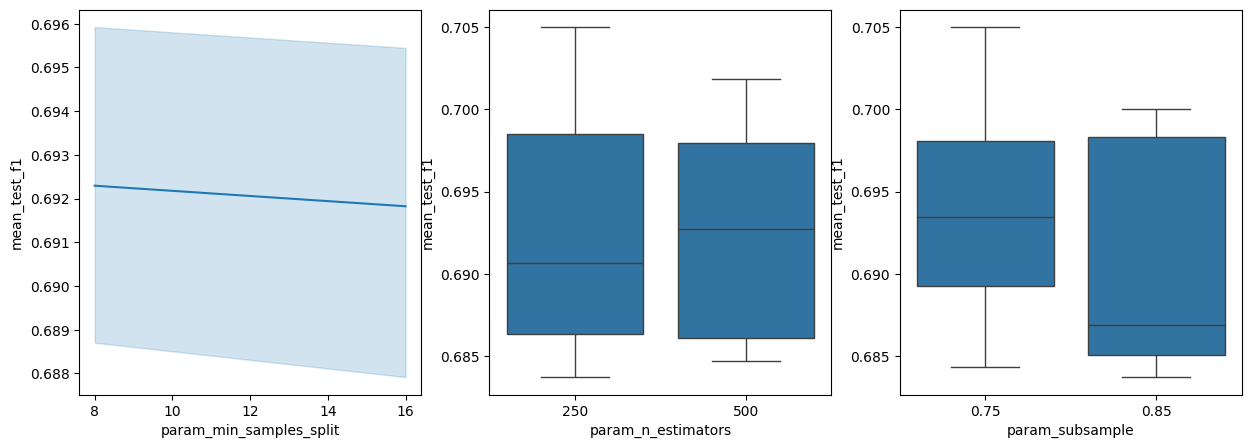

In [42]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
sb.lineplot(data=gb_cv_results_3, x='param_min_samples_split', y='mean_test_f1', ax=ax[0])
sb.boxplot(data=gb_cv_results_3, x='param_n_estimators', y='mean_test_f1', ax=ax[1])
sb.boxplot(data=gb_cv_results_3, x='param_subsample', y='mean_test_f1', ax=ax[2])

In [44]:
gb_scores_test_3.describe()

,accuracy,precision,recall,f1,roc_auc
count,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.770573,0.714597,0.689372,0.697413,0.885359
std,0.012460,0.015057,0.009555,0.010704,0.007104
min,0.762712,0.703850,0.681392,0.690043,0.878815
25%,0.763390,0.705992,0.684078,0.691273,0.881581
50%,0.764068,0.708134,0.686764,0.692504,0.884348
75%,0.774503,0.719970,0.693362,0.701097,0.888631
max,0.784939,0.731807,0.699960,0.709691,0.892914


In [45]:
gb_scores_train_3.describe()

,accuracy,precision,recall,f1,roc_auc
count,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.875451,0.864855,0.826050,0.841604,0.964374
std,0.023465,0.032496,0.030989,0.031893,0.012260
min,0.848762,0.827444,0.790676,0.805056,0.950272
25%,0.866754,0.854254,0.814870,0.830509,0.960313
50%,0.884746,0.881064,0.839065,0.855961,0.970354
75%,0.888795,0.883561,0.843737,0.859879,0.971425
max,0.892845,0.886059,0.848410,0.863796,0.972496


In [46]:
gb_estimators_3

[GradientBoostingClassifier(max_depth=2, min_samples_split=8, n_estimators=250,
                            random_state=15, subsample=0.75),
 GradientBoostingClassifier(max_depth=2, min_samples_split=16, n_estimators=500,
                            random_state=15, subsample=0.75),
 GradientBoostingClassifier(max_depth=2, min_samples_split=8, n_estimators=500,
                            random_state=15, subsample=0.75)]

In [ ]:
gb_params = {
    "n_estimators": [500],
    "learning_rate": [0.1],
    'subsample': [0.75],
    'min_samples_split': [8, 12], 
    'max_depth': [2],   
}

gb_estimators_4, gb_scores_train_4, gb_scores_test_4, gb_cv_results_4 = train(df_features, df_targets,
    GradientBoostingClassifier(random_state=global_random_state),
    gb_params, outer_splits=5, inner_splits=4)

*
*
*
*
*


<Axes: xlabel='param_min_samples_split', ylabel='mean_test_f1'>

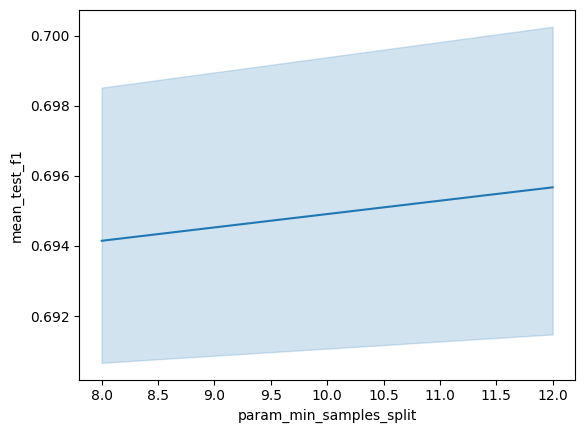

In [48]:
sb.lineplot(data=gb_cv_results_4, x='param_min_samples_split', y='mean_test_f1')

In [50]:
gb_scores_test_4.describe()

,accuracy,precision,recall,f1,roc_auc
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.778936,0.727845,0.700005,0.709118,0.889834
std,0.012383,0.018881,0.011330,0.013720,0.005532
min,0.762712,0.705406,0.686979,0.695321,0.884980
25%,0.774011,0.716742,0.691706,0.696679,0.885892
50%,0.775141,0.722565,0.698072,0.706966,0.887076
75%,0.790960,0.744280,0.711029,0.722890,0.893498
max,0.791855,0.750234,0.712238,0.723732,0.897726


In [51]:
gb_scores_train_4.describe()

,accuracy,precision,recall,f1,roc_auc
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.876187,0.865271,0.826953,0.842325,0.965792
std,0.002620,0.002560,0.004885,0.004152,0.000895
min,0.872563,0.863161,0.818997,0.835956,0.964543
25%,0.875141,0.863513,0.826616,0.841583,0.965318
50%,0.876236,0.864184,0.827839,0.842579,0.966096
75%,0.877366,0.866133,0.829277,0.844285,0.966099
max,0.879627,0.869364,0.832038,0.847220,0.966903


In [52]:
gb_estimators_4

[GradientBoostingClassifier(max_depth=2, min_samples_split=12, n_estimators=500,
                            random_state=15, subsample=0.75),
 GradientBoostingClassifier(max_depth=2, min_samples_split=12, n_estimators=500,
                            random_state=15, subsample=0.75),
 GradientBoostingClassifier(max_depth=2, min_samples_split=8, n_estimators=500,
                            random_state=15, subsample=0.75),
 GradientBoostingClassifier(max_depth=2, min_samples_split=12, n_estimators=500,
                            random_state=15, subsample=0.75),
 GradientBoostingClassifier(max_depth=2, min_samples_split=12, n_estimators=500,
                            random_state=15, subsample=0.75)]

In [ ]:
gb_params = {
    "n_estimators": [500],
    "learning_rate": [0.1],
    'subsample': [0.75],
    'min_samples_split': [12],
    'min_samples_leaf':[4, 8, 12], 
    'max_depth': [2],   
}

gb_estimators_5, gb_scores_train_5, gb_scores_test_5, gb_cv_results_5 = train(df_features, df_targets,
    GradientBoostingClassifier(random_state=global_random_state),
    gb_params, outer_splits=5, inner_splits=4)

<Axes: xlabel='param_min_samples_leaf', ylabel='mean_test_f1'>

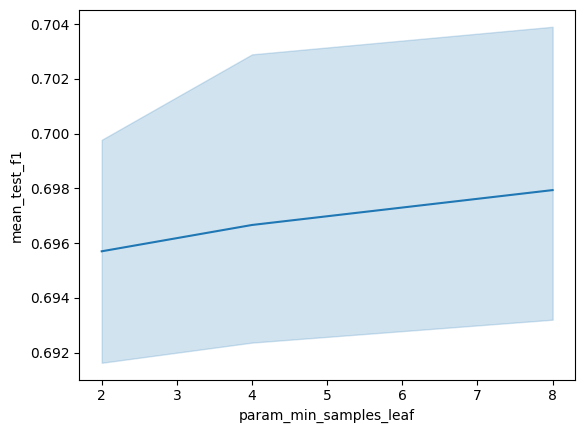

In [86]:
sb.lineplot(data=gb_cv_results_5, x='param_min_samples_leaf', y='mean_test_f1')

In [87]:
gb_scores_test_5.describe()

,accuracy,precision,recall,f1,roc_auc
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.779389,0.728210,0.700023,0.709183,0.889368
std,0.012646,0.021247,0.012863,0.015233,0.005390
min,0.769492,0.709176,0.684640,0.692450,0.884074
25%,0.769492,0.711943,0.693880,0.700271,0.885693
50%,0.771751,0.718277,0.694805,0.702675,0.887736
75%,0.790960,0.745480,0.712238,0.723080,0.891859
max,0.795249,0.756173,0.714550,0.727439,0.897479


In [88]:
gb_estimators_5

[GradientBoostingClassifier(max_depth=2, min_samples_leaf=2,
                            min_samples_split=12, n_estimators=500,
                            random_state=15, subsample=0.75),
 GradientBoostingClassifier(max_depth=2, min_samples_leaf=4,
                            min_samples_split=12, n_estimators=500,
                            random_state=15, subsample=0.75),
 GradientBoostingClassifier(max_depth=2, min_samples_leaf=8,
                            min_samples_split=12, n_estimators=500,
                            random_state=15, subsample=0.75),
 GradientBoostingClassifier(max_depth=2, min_samples_leaf=8,
                            min_samples_split=12, n_estimators=500,
                            random_state=15, subsample=0.75),
 GradientBoostingClassifier(max_depth=2, min_samples_leaf=4,
                            min_samples_split=12, n_estimators=500,
                            random_state=15, subsample=0.75)]

In [57]:
gb_params = {
    "n_estimators": [500],
    "learning_rate": [0.1],
    'subsample': [0.75],
    'min_samples_split': [12], 
    'max_depth': [2],   
}

gb_estimators_final, gb_scores_train_final, gb_scores_test_final, gb_cv_results_final = train(df_features, df_targets,
    GradientBoostingClassifier(random_state=global_random_state),
    gb_params, outer_splits=5, inner_splits=4)

*
*
*
*
*


In [76]:
gb_scores_test_final.describe()

,accuracy,precision,recall,f1,roc_auc
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.777806,0.725980,0.698261,0.707229,0.889719
std,0.014337,0.021875,0.013407,0.016273,0.005640
min,0.757062,0.696081,0.682986,0.687234,0.884980
25%,0.774011,0.716742,0.686979,0.695321,0.885315
50%,0.775141,0.722565,0.698072,0.706966,0.887076
75%,0.790960,0.744280,0.711029,0.722890,0.893498
max,0.791855,0.750234,0.712238,0.723732,0.897726


In [77]:
gb_scores_train_final.describe()

,accuracy,precision,recall,f1,roc_auc
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.875848,0.864682,0.826488,0.841815,0.965767
std,0.002720,0.003145,0.004891,0.004268,0.000857
min,0.872563,0.861239,0.818997,0.835956,0.964543
25%,0.874541,0.863161,0.825511,0.840031,0.965318
50%,0.875141,0.863513,0.826616,0.841583,0.966096
75%,0.877366,0.866133,0.829277,0.844285,0.966099
max,0.879627,0.869364,0.832038,0.847220,0.966778


LR

In [ ]:
lr_params = {
    'C': [0.01, 0.1, 1, 1.5, 5, 10],
    "solver": ["lbfgs", "newton-cg", "newton-cholesky", "sag", "saga"],   
    'tol': [1e-2, 1e-3, 1e-4, 1e-5],
    'max_iter': [100],
}

lr_estimators, lr_scores_train, lr_scores_test, lr_cv_results = train(df_features, df_targets,
    LogisticRegression(random_state=global_random_state),
    lr_params, outer_splits=5, inner_splits=4)

<Axes: xlabel='param_solver', ylabel='mean_test_f1'>

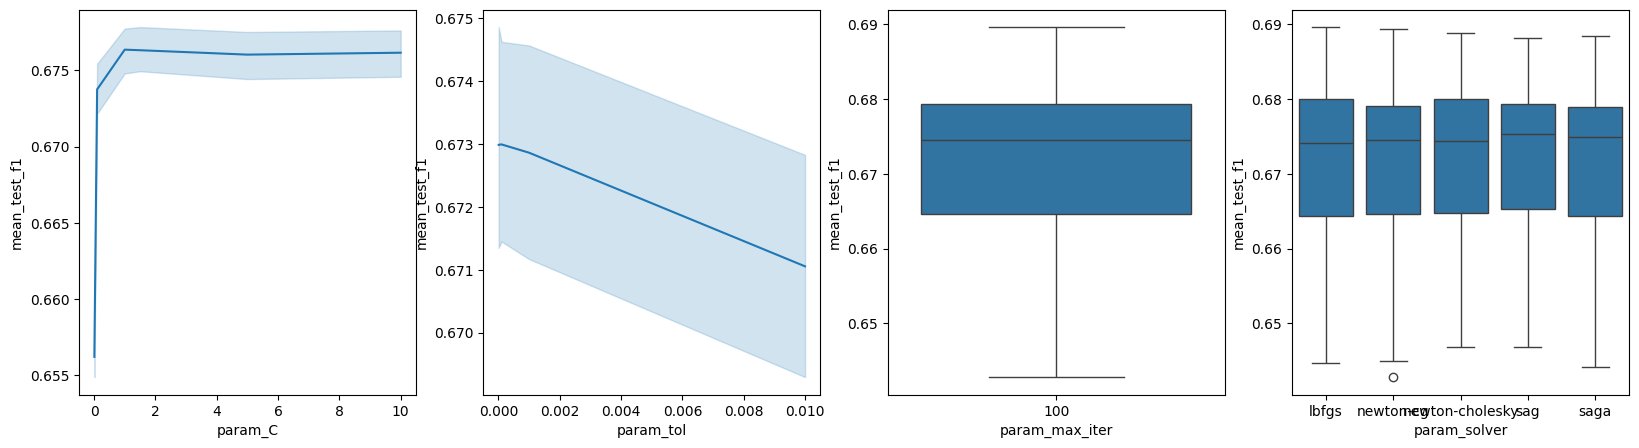

In [62]:
fig, ax = plt.subplots(1,4, figsize=(20,5))
sb.lineplot(data=lr_cv_results, x='param_C', y='mean_test_f1', ax=ax[0])
sb.lineplot(data=lr_cv_results, x='param_tol', y='mean_test_f1', ax=ax[1])
sb.boxplot(data=lr_cv_results, x='param_max_iter', y='mean_test_f1', ax=ax[2])
sb.boxplot(data=lr_cv_results, x='param_solver', y='mean_test_f1', ax=ax[3])

In [60]:
lr_scores_test.describe()

,accuracy,precision,recall,f1,roc_auc
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.765372,0.707594,0.668221,0.676151,0.880329
std,0.013010,0.019314,0.013443,0.014171,0.005605
min,0.744633,0.676538,0.647256,0.654383,0.870457
25%,0.760452,0.705416,0.663436,0.671777,0.881511
50%,0.772624,0.713037,0.672873,0.680654,0.882548
75%,0.774011,0.714173,0.675926,0.681680,0.882869
max,0.775141,0.728806,0.681617,0.692259,0.884259


In [61]:
lr_scores_train.describe()

,accuracy,precision,recall,f1,roc_auc
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.775204,0.721149,0.680511,0.689531,0.890374
std,0.003806,0.006750,0.005205,0.006104,0.000987
min,0.770621,0.714039,0.675290,0.683672,0.889536
25%,0.773100,0.715898,0.676762,0.684543,0.889562
50%,0.774513,0.721329,0.680348,0.689993,0.890364
75%,0.777338,0.723372,0.681517,0.690497,0.890444
max,0.780446,0.731105,0.688636,0.698949,0.891964


In [63]:
print_estimators(lr_estimators)

LogisticRegression(C=1, random_state=15, tol=0.001)
LogisticRegression(C=0.1, random_state=15, tol=0.001)
LogisticRegression(C=10, random_state=15, solver='sag', tol=0.01)
LogisticRegression(C=1, random_state=15, tol=0.001)
LogisticRegression(C=1.5, random_state=15, solver='newton-cg')


In [64]:
lr_params = {
    'C': [0.1, 1, 1.5, 5, 10],
    "solver": ["lbfgs"],   
    'tol': [1e-2, 1e-3, 1e-4],
    'max_iter': [100, 250, 500],
}

lr_estimators_2, lr_scores_train_2, lr_scores_test_2, lr_cv_results_2 = train(df_features, df_targets,
    LogisticRegression(random_state=global_random_state),
    lr_params, outer_splits=5, inner_splits=4)

*
*
*
*
*


<Axes: xlabel='param_max_iter', ylabel='mean_test_f1'>

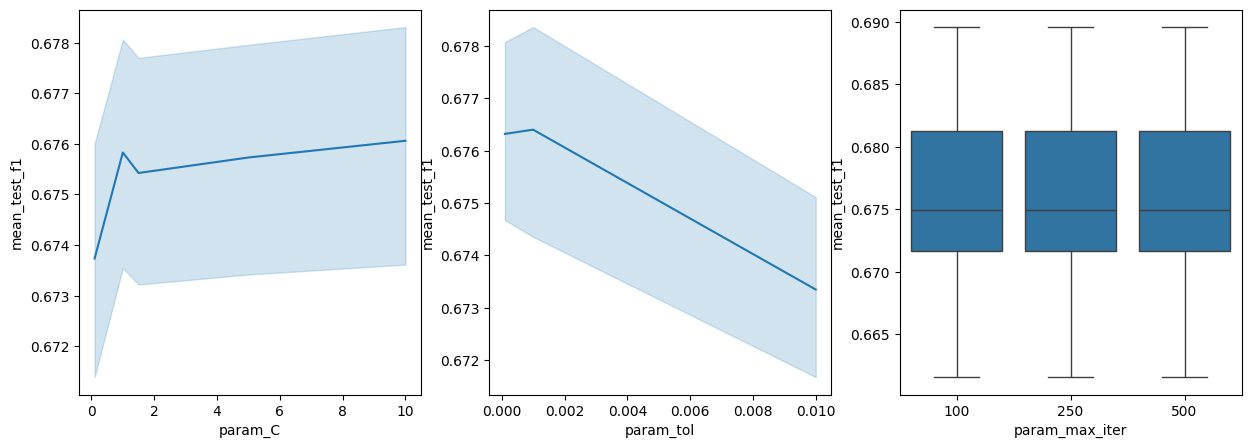

In [65]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
sb.lineplot(data=lr_cv_results_2, x='param_C', y='mean_test_f1', ax=ax[0])
sb.lineplot(data=lr_cv_results_2, x='param_tol', y='mean_test_f1', ax=ax[1])
sb.boxplot(data=lr_cv_results_2, x='param_max_iter', y='mean_test_f1', ax=ax[2])

In [67]:
lr_scores_test_2.describe()

,accuracy,precision,recall,f1,roc_auc
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.766051,0.708576,0.669753,0.677865,0.880379
std,0.013541,0.019743,0.014431,0.015090,0.005632
min,0.744633,0.676538,0.647256,0.654383,0.870457
25%,0.760452,0.705416,0.663436,0.671777,0.881504
50%,0.774887,0.715194,0.677092,0.685351,0.882808
75%,0.775141,0.716926,0.679364,0.685553,0.882869
max,0.775141,0.728806,0.681617,0.692259,0.884259


In [68]:
lr_scores_train_2.describe()

,accuracy,precision,recall,f1,roc_auc
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.775091,0.720896,0.680389,0.689364,0.890402
std,0.003906,0.006885,0.005259,0.006154,0.000964
min,0.770339,0.713536,0.675101,0.683440,0.889562
25%,0.773100,0.715898,0.676762,0.684543,0.889646
50%,0.774230,0.720567,0.679928,0.689391,0.890397
75%,0.777338,0.723372,0.681517,0.690497,0.890444
max,0.780446,0.731105,0.688636,0.698949,0.891964


In [69]:
lr_estimators_2

[LogisticRegression(C=1, random_state=15, tol=0.001),
 LogisticRegression(C=0.1, random_state=15, tol=0.001),
 LogisticRegression(C=1, random_state=15),
 LogisticRegression(C=1, random_state=15, tol=0.001),
 LogisticRegression(C=10, random_state=15)]

In [70]:
lr_params = {
    'C': [1],
    "solver": ["lbfgs"],   
    'tol': [1e-3],
    'max_iter': [100],
}

lr_estimators_final, lr_scores_train_final, lr_scores_test_final, lr_cv_results_final = train(df_features, df_targets,
    LogisticRegression(random_state=global_random_state),
    lr_params, outer_splits=5, inner_splits=4)

*
*
*
*
*


In [72]:
lr_scores_test_final.describe()

,accuracy,precision,recall,f1,roc_auc
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.765146,0.706670,0.668607,0.676385,0.880766
std,0.011609,0.017973,0.010989,0.012055,0.005096
min,0.746893,0.678900,0.652708,0.659320,0.871795
25%,0.760452,0.705416,0.663436,0.671777,0.881716
50%,0.771493,0.708432,0.671699,0.679120,0.882869
75%,0.771751,0.711798,0.673578,0.679448,0.883191
max,0.775141,0.728806,0.681617,0.692259,0.884259


In [73]:
lr_scores_train_final.describe()

,accuracy,precision,recall,f1,roc_auc
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.774978,0.720460,0.680052,0.688816,0.890517
std,0.002950,0.005024,0.004940,0.005727,0.001370
min,0.771751,0.715635,0.675308,0.683270,0.889562
25%,0.773100,0.715898,0.676762,0.684543,0.889591
50%,0.773947,0.719994,0.678835,0.688079,0.890109
75%,0.777338,0.723372,0.681517,0.690497,0.890444
max,0.778751,0.727400,0.687841,0.697694,0.892877


In [82]:
slutt_resultat = pd.DataFrame({
    'Metric': ['Accuracy:','Precision:','Recall:', 'F1:', 'Roc_auc'],
    'RandomForest Train': [rf_scores_train_final['accuracy'].mean(),rf_scores_train_final['precision'].mean(), rf_scores_train_final['recall'].mean(), rf_scores_train_final['f1'].mean(), rf_scores_train_final['roc_auc'].mean()],
    'RandomForest Test': [rf_scores_test_final['accuracy'].mean(),rf_scores_test_final['precision'].mean(), rf_scores_test_final['recall'].mean(), rf_scores_test_final['f1'].mean(), rf_scores_test_final['roc_auc'].mean()],
    'Gradient Boosting Train': [gb_scores_train_final['accuracy'].mean(),gb_scores_train_final['precision'].mean(), gb_scores_train_final['recall'].mean(), gb_scores_train_final['f1'].mean(), gb_scores_train_final['roc_auc'].mean()],
    'Gradient Boosting Test': [gb_scores_test_final['accuracy'].mean(),gb_scores_test_final['precision'].mean(), gb_scores_test_final['recall'].mean(), gb_scores_test_final['f1'].mean(), gb_scores_test_final['roc_auc'].mean()],
    'Logistic Regression Train': [lr_scores_train_final['accuracy'].mean(),lr_scores_train_final['precision'].mean(), lr_scores_train_final['recall'].mean(), lr_scores_train_final['f1'].mean(), lr_scores_train_final['roc_auc'].mean()],
    'Logistic Regression Test': [lr_scores_test_final['accuracy'].mean(),lr_scores_test_final['precision'].mean(), lr_scores_test_final['recall'].mean(), lr_scores_test_final['f1'].mean(), lr_scores_test_final['roc_auc'].mean()]
    })
slutt_resultat.set_index('Metric', inplace=True)
slutt_resultat

,RandomForest Train,RandomForest Test,Gradient Boosting Train,Gradient Boosting Test,Logistic Regression Train,Logistic Regression Test
Metric,,,,,,
Accuracy:,0.968976,0.778934,0.875848,0.777806,0.774978,0.765146
Precision:,0.977764,0.738182,0.864682,0.725980,0.720460,0.706670
Recall:,0.953909,0.688615,0.826488,0.698261,0.680052,0.668607
F1:,0.964795,0.700557,0.841815,0.707229,0.688816,0.676385
Roc_auc,0.999201,0.890295,0.965767,0.889719,0.890517,0.880766


In [83]:
def split_targets_and_features(data):
    targets = data['Target']
    features = pd.DataFrame(StandardScaler().fit_transform(data.drop("Target", axis=1)), columns=data.drop("Target", axis=1).columns)
    
    return [features, targets]

def split_dataset(data):
    data['Target'] = pd.Series(np.array(LabelEncoder().fit_transform(data['Target'])))
    train = data.groupby("Target", group_keys=False)[df.columns].sample(frac=0.8)
    test = data.drop(train.index)
    train = split_targets_and_features(train)
    test = split_targets_and_features(test)

    return train, test

slutt_train, slutt_test = split_dataset(df)

In [ ]:
gb_params = {
    "n_estimators": [500],
    "learning_rate": [0.1],
    'subsample': [0.75],
    'min_samples_split': [12], 
    'max_depth': [2],   
}


gb_model = GradientBoostingClassifier(max_depth=2, min_samples_leaf=2, n_estimators=500)
gb_model.fit(slutt_train[0], slutt_train[1])

rf_model_pred = rf_model.predict_proba(slutt_test[0])
unik_tr = np.unique(rf_model_pred[:,0])
for threshold in unik_tr:
    threshold_predictions = (rf_model_pred[:,0] < threshold)*1

    precision = precision_score(slutt_test[1], threshold_predictions, zero_division=1, average='macro')
    recall = recall_score(slutt_test[1], threshold_predictions, average='macro')

    print(f'Threshold: {threshold:.2f}',precision, recall)

Threshold: 0.00 0.7736346516007533 0.3333333333333333
Threshold: 0.00 0.44042232277526394 0.3333333333333333
Threshold: 0.00 0.4405436013590034 0.3333333333333333
Threshold: 0.00 0.4406651549508693 0.3333333333333333
Threshold: 0.01 0.44078698448732495 0.3333333333333333
Threshold: 0.01 0.4409090909090909 0.3333333333333333
Threshold: 0.01 0.441031475161168 0.3333333333333333
Threshold: 0.01 0.44115413819286253 0.3333333333333333
Threshold: 0.01 0.44127708095781076 0.3333333333333333
Threshold: 0.01 0.4414003044140031 0.3333333333333333
Threshold: 0.01 0.4415238095238095 0.3333333333333333
Threshold: 0.01 0.4416475972540046 0.3333333333333333
Threshold: 0.01 0.44177166857579225 0.3333333333333333
Threshold: 0.01 0.4418960244648318 0.3333333333333333
Threshold: 0.01 0.4420206659012629 0.3333333333333333
Threshold: 0.01 0.4421455938697318 0.3333333333333333
Threshold: 0.01 0.442270809359417 0.3333333333333333
Threshold: 0.01 0.4423963133640553 0.3333333333333333
Threshold: 0.01 0.4425221

In [175]:
class ThresholdClassifier(BaseEstimator, ClassifierMixin):
   def __init__(self, estimator, threshold=0.5): 
       self.estimator = estimator
       self.threshold = threshold

   def fit(self, X, y):
       if hasattr(self.estimator, 'classes_'):
            self.classes_ = self.estimator.classes_
            return self
       self.estimator.fit(X, y)
       return self

   def predict(self, X):
    #    proba = self.estimator.predict_proba(X)[:, 1]
       proba = self.estimator.predict_proba(X)[:, 0]
       return (proba < self.threshold).astype(int)

   def predict_proba(self, X):
       return self.estimator.predict_proba(X)

In [189]:
rf_threshold = ThresholdClassifier(estimator=rf_model, threshold=1.0)
predictions = rf_threshold.predict(slutt_test[0])
print(precision_score(slutt_test[1], predictions, zero_division=1, average='macro'))
print(recall_score(slutt_test[1], predictions, average='macro'))


0.7265536723163842
0.3333333333333333


### Oblig 4